In [21]:
import numpy as np
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
#from surprise import SVD
#from surprise import Dataset
#from surprise import Reader
#from surprise.model_selection import train_test_split
#from surprise import accuracy



%matplotlib inline

import tensorflow.keras as tf

In [22]:

data = pd.read_csv("cocktail-data/drinks.csv")
columns_to_keep = ['Cocktail Name', 'Ingredients', 'Garnish', 'Glassware', 'Preparation']
data = data[columns_to_keep]


In [23]:
data.head()



,Cocktail Name,Ingredients,Garnish,Glassware,Preparation
0,Flor de Amaras,"1.5 oz Mezcal, 1 oz Hibiscus Simple Syrup*, .5...",Marigold Petals,NaN,*Hibiscus Simple Syrup:\n1:1 w/ a cup of dried...
1,The Happy Place,"2 oz Junipero Gin, .75 oz House-made Cranberry...","Dehydrated Lemon Wheel, Sprig of Rosemary",NaN,*House-made Cranberry syrup: \n-- 2 cups Fresh...
2,Bon Voyage Pisco Punch,"1500 ml BarSol Selecto Italia Pisco, 750 ml Le...",NaN,Punch Bowl,*Pineapple Gomme: \nMix equal parts (1.5 cups)...
3,Still Life of a Pineapple,"1.5 oz BarSol Primero Quebranta Pisco, .75 oz ...",NaN,NaN,*Pineapple Syrup:\n<em>Equal parts pineapple b...
4,The Bittered Valley,"1.25 oz Luxardo Maraschino Liqueur, 4 drops Ac...",NaN,NaN,"1st glass ingredients:\nLuxardo Maraschino, Ac..."


In [24]:
percentNull = (data.isnull().sum())/(data.count())
print((percentNull))


Cocktail Name    0.000000
Ingredients      0.000000
Garnish          0.313576
Glassware        0.416495
Preparation      0.070093
dtype: float64


In [25]:
summary_stats = data.describe()
print(summary_stats)

       Cocktail Name                                        Ingredients  \
count            687                                                687   
unique           684                                                686   
top      Rita's Song  1 oz No.3 London Dry Gin, 1 oz Tempus Fugit Al...   
freq               2                                                  2   

               Garnish Glassware  \
count              523       485   
unique             318        66   
top     Luxardo Cherry     Coupe   
freq                32       107   

                                              Preparation  
count                                                 642  
unique                                                630  
top     Shake until very cold; double strain into a ch...  
freq                                                    3  


In [28]:
from sklearn.feature_extraction.text import CountVectorizer
df = pd.DataFrame(data)

# Fill NaN values with empty strings or any other appropriate placeholders
df['Ingredients'].fillna('', inplace=True)

# Define a regular expression pattern to match quantities like "1.5 oz" or "10"
quantity_pattern = r'\d+(\.\d+)?\s*(oz|ml|g|cl)?'

# Replace quantities with a special token, preserving the unit if present
df['Ingredients'] = df['Ingredients'].str.replace(quantity_pattern, 'QUANTITY_TOKEN')

# Tokenize 'Ingredients' column
vectorizer = CountVectorizer()
ingredient_matrix = vectorizer.fit_transform(df['Ingredients'])
ingredient_df = pd.DataFrame(ingredient_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Concatenate the tokenized columns back to the original DataFrame
df = pd.concat([df, ingredient_df], axis=1)

# Drop the original text-based 'Ingredients' column
df.drop(['Ingredients'], axis=1, inplace=True)

print(df)



                 Cocktail Name                                    Garnish  \
0               Flor de Amaras                            Marigold Petals   
1              The Happy Place  Dehydrated Lemon Wheel, Sprig of Rosemary   
2       Bon Voyage Pisco Punch                                        NaN   
3    Still Life of a Pineapple                                        NaN   
4          The Bittered Valley                                        NaN   
..                         ...                                        ...   
682         The Negroni Bianco                                        NaN   
683           Match Grip Julep                                        NaN   
684             The Dry Cruise                       Edible Flower, Straw   
685                   Red Hook                                        NaN   
686                 Union Jack                                        NaN   

      Glassware                                        Preparation  10  101

In [ ]:
# Combine the tokenized 'Ingredients' and 'Garnish' DataFrames into one
combined_df = pd.concat([ingredient_df, garnish_df], axis=1)

# Optionally, you can also add other columns like 'Cocktail Name', 'Glassware', etc. if needed
combined_df = pd.concat([df[['Cocktail Name', 'Glassware']], combined_df], axis=1)

print(combined_df)

                 Cocktail Name   Glassware  abano  abbott  abita  abricot  \
0               Flor de Amaras         NaN      0       0      0        0   
1              The Happy Place         NaN      0       0      0        0   
2       Bon Voyage Pisco Punch  Punch Bowl      0       0      0        0   
3    Still Life of a Pineapple         NaN      0       0      0        0   
4          The Bittered Valley         NaN      1       0      0        0   
..                         ...         ...    ...     ...    ...      ...   
682         The Negroni Bianco         NaN      0       0      0        0   
683           Match Grip Julep         NaN      0       0      0        0   
684             The Dry Cruise         NaN      0       0      0        0   
685                   Red Hook         NaN      0       0      0        0   
686                 Union Jack         NaN      0       0      0        0   

     absinthe  absolut  acacia  acholado  ...  wedges  wheel  wheels  white

In [ ]:
# Split ingredients by comma and count the number of ingredients (excluding measurements and units)
def count_ingredients(ingredients):
    ingredient_list = [re.sub(r'\d+\s*oz\s*', '', ingredient).strip() for ingredient in ingredients.split(',')]
    return len(ingredient_list)

data['Ingredient Count'] = data['Ingredients'].apply(count_ingredients)

# Find the most common ingredients (excluding measurements and units)
ingredients_list = [re.sub(r'\d+(\.\d+)?\s*oz\s*', '', ingredient).strip() for ingredients in data['Ingredients'] for ingredient in ingredients.split(',')]
common_ingredients = pd.Series(ingredients_list).value_counts()

print("Ingredient Count Statistics:")
print(data['Ingredient Count'].describe())

print("\nTop 10 Common Ingredients:")
print(common_ingredients.head(10))


Ingredient Count Statistics:
count    687.000000
mean       4.707424
std        1.409150
min        1.000000
25%        4.000000
50%        5.000000
75%        5.000000
max       13.000000
Name: Ingredient Count, dtype: float64

Top 10 Common Ingredients:
.Lemon Juice                   76
.Luxardo Maraschino Liqueur    65
No.3 London Dry Gin            63
Junipero Gin                   62
.King's Ginger Liqueur         42
.Lime Juice                    38
H by HINE                      38
King's Ginger Liqueur          36
.Fresh Lemon Juice             32
Pink Pigeon Rum                29
dtype: int64


In [ ]:
df['Text'] = data['Ingredients'] + ' ' + data['Garnish']

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the TF-IDF vectorizer on the combined text
feature_matrix = tfidf_vectorizer.fit_transform(df['Text'])
cosine_sim_matrix = cosine_similarity(feature_matrix, feature_matrix)



  (0, 831)	0.4690145731311455
  (0, 691)	0.44121468912553546
  (0, 1165)	0.2358184465111233
  (0, 1026)	0.2525613105480118
  (0, 1118)	0.2636183305167333
  (0, 601)	0.11628676694295816
  (0, 659)	0.17299485071426432
  (0, 1085)	0.1404849298567641
  (0, 1008)	0.20288310784507016
  (0, 552)	0.4061909773342865
  (0, 714)	0.28334266211697434
  (0, 799)	0.21642821686795033
  (1, 949)	0.24195208831873125
  (1, 774)	0.19264604704629676
  (1, 1045)	0.15132731852304215
  (1, 1172)	0.1380844989290056
  (1, 358)	0.21992682110494233
  (1, 634)	0.2692328623773768
  (1, 725)	0.2692328623773768
  (1, 148)	0.08130261425616332
  (1, 355)	0.2692328623773768
  (1, 399)	0.2692328623773768
  (1, 461)	0.2692328623773768
  (1, 353)	0.08097187418004728
  (1, 152)	0.19871308444513153
  :	:
  (684, 644)	0.09691363457823009
  (684, 30)	0.099652141234895
  (684, 1118)	0.20176598596646747
  (684, 601)	0.0890025899986096
  (684, 1085)	0.10752317689903895
  (684, 799)	0.2760800212042071
  (685, 711)	0.50042142898584

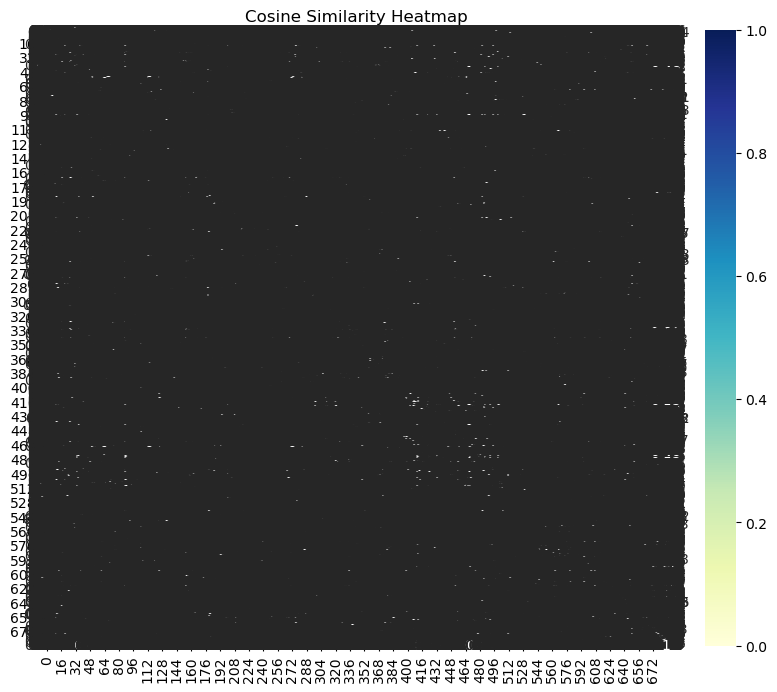

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'cosine_sim_matrix' is your cosine similarity matrix

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim_matrix, annot=True, cmap='YlGnBu', linewidths=0.5)
plt.title('Cosine Similarity Heatmap')
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest = train_test_split(data, test_size=0.2, random_state=1)
print(f"Shape of train data: {Xtrain.shape}")
print(f"Shape of test data: {Xtest.shape}")

Shape of train data: (549, 6)
Shape of test data: (138, 6)


## CREATE A NEURAL NETWORK

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity


# Calculate cosine similarity matrix
cosine_sim_matrix = cosine_similarity(feature_matrix, feature_matrix)

# Create a function to recommend cocktails
def recommend_cocktails(cocktail_name, cosine_sim_matrix, data):
    # Find the index of the cocktail with the given name
    idx = data[data['Cocktail Name'] == cocktail_name].index[0]

    # Get the cosine similarity scores for the given cocktail
    sim_scores = list(enumerate(cosine_sim_matrix[idx]))

    # Sort the cocktails based on similarity scores in descending order
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the top N similar cocktails (excluding the input cocktail itself)
    top_N = 5  # You can adjust this value to control the number of recommendations
    similar_cocktails = sim_scores[1:(top_N + 1)]

    # Extract the indices of similar cocktails
    cocktail_indices = [x[0] for x in similar_cocktails]

    # Return the names of recommended cocktails
    recommended_cocktails = data['Cocktail Name'].iloc[cocktail_indices]

    return recommended_cocktails

# Example usage:
input_cocktail = 'Down the Rabbit Hole'
recommendations = recommend_cocktails(input_cocktail, cosine_sim_matrix, df)

print(f'Recommended cocktails for {input_cocktail}:')
print(recommendations)


Recommended cocktails for Down the Rabbit Hole:
265           Juniperotivo
260          The Southside
662         Southside Fizz
678    Spring Fling Sipper
172           Radice Amara
Name: Cocktail Name, dtype: object


In [ ]:
import h5py

# Assuming 'cosine_sim_matrix' is your cosine similarity matrix

# Define the file path and filename for the .h5 file
h5_file_path = 'cosine_similarity_matrix.h5'

# Create an HDF5 file and save the cosine similarity matrix
with h5py.File(h5_file_path, 'w') as hf:
    hf.create_dataset('cosine_similarity', data=cosine_sim_matrix)

print(f'Cosine similarity matrix saved to {h5_file_path}')


Cosine similarity matrix saved to cosine_similarity_matrix.h5


In [112]:
import pandas as pd
import zipfile

# Specify the path to the zip file and the names of the CSV files within the zip
zip_file_path = "cocktail-data/dataset.zip"
csv_file_name1 = 'RAW_recipes.csv'
csv_file_name2 = 'RAW_interactions.csv'  # Replace with the actual name of your second CSV file

# Initialize two DataFrames to store the data from the two CSV files
df1 = None
df2 = None

# Open the zip file and read the first CSV file into the first DataFrame
with zipfile.ZipFile(zip_file_path, 'r') as zip_file:
    with zip_file.open(csv_file_name1) as csv_file_in_zip:
        df_recipes = pd.read_csv(csv_file_in_zip)

# Open the zip file again and read the second CSV file into the second DataFrame
with zipfile.ZipFile(zip_file_path, 'r') as zip_file:
    with zip_file.open(csv_file_name2) as csv_file_in_zip:
        df_reviews = pd.read_csv(csv_file_in_zip)

# Now you have two DataFrames, df1 and df2, containing data from the two CSV files
# You can merge them if needed

# Merge the DataFrames on 'recipe_id'
df_recipes.rename(columns={'id': 'recipe_id'}, inplace=True)




In [113]:
df_recipes.head()

(df_reviews.head())

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


In [114]:
columns_to_drop = ['contributor_id', 'description','submitted']

df_recipes = df_recipes.drop(columns=columns_to_drop)



In [115]:
combined_df = pd.merge(df_reviews, df_recipes, on='recipe_id', how='inner')

combined_df.head()


,user_id,recipe_id,date,rating,review,name,minutes,tags,nutrition,n_steps,steps,ingredients,n_ingredients
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...,white bean green chile pepper soup,495,"['weeknight', 'time-to-make', 'course', 'main-...","[204.8, 5.0, 9.0, 26.0, 24.0, 2.0, 10.0]",4,"['combine beans , onion , chilies , 1 / 2 teas...","['great northern beans', 'yellow onion', 'dice...",9
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall...",white bean green chile pepper soup,495,"['weeknight', 'time-to-make', 'course', 'main-...","[204.8, 5.0, 9.0, 26.0, 24.0, 2.0, 10.0]",4,"['combine beans , onion , chilies , 1 / 2 teas...","['great northern beans', 'yellow onion', 'dice...",9
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...,devilicious cookie cake delights,20,"['30-minutes-or-less', 'time-to-make', 'course...","[132.3, 11.0, 39.0, 5.0, 4.0, 11.0, 5.0]",5,"['blend together cake mix , oil and eggs', 'ad...","[""devil's food cake mix"", 'vegetable oil', 'eg...",4
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...,baked potato toppings,10,"['15-minutes-or-less', 'time-to-make', 'course...","[2786.2, 342.0, 134.0, 290.0, 161.0, 301.0, 42.0]",3,['pick whichever topping you want to use and c...,"['mayonnaise', 'salsa', 'cheddar cheese', 'ref...",13
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin...",baked potato toppings,10,"['15-minutes-or-less', 'time-to-make', 'course...","[2786.2, 342.0, 134.0, 290.0, 161.0, 301.0, 42.0]",3,['pick whichever topping you want to use and c...,"['mayonnaise', 'salsa', 'cheddar cheese', 'ref...",13


In [116]:
combined_df = combined_df[combined_df['tags'].str.contains('cocktails', case=False, na=False)]

combined_df.rename(columns={'id': 'recipe_id'}, inplace=True)

combined_df.head()

,user_id,recipe_id,date,rating,review,name,minutes,tags,nutrition,n_steps,steps,ingredients,n_ingredients
84,296027,182985,2007-05-19,4,"Very nice,fresh summertime martini. I will ma...",watermelon martini,50,"['60-minutes-or-less', 'time-to-make', 'course...","[622.4, 3.0, 426.0, 0.0, 21.0, 1.0, 43.0]",4,['place all ingredients in a shaker and shake ...,"['vodka', 'lime juice', 'triple sec', 'waterme...",6
691,452940,367080,2009-07-10,4,"Your right, we had to add quite a bit more app...",apple blossom,2,"['15-minutes-or-less', 'time-to-make', 'course...","[192.0, 0.0, 21.0, 0.0, 0.0, 0.0, 2.0]",3,"['pour the brandy , apple juice , and lemon ju...","['brandy', 'apple juice', 'lemon juice', 'lemo...",4
692,162826,367080,2009-10-04,5,"WOW!\nThis is tasty, Boomie! I used exactly th...",apple blossom,2,"['15-minutes-or-less', 'time-to-make', 'course...","[192.0, 0.0, 21.0, 0.0, 0.0, 0.0, 2.0]",3,"['pour the brandy , apple juice , and lemon ju...","['brandy', 'apple juice', 'lemon juice', 'lemo...",4
1734,303545,259553,2009-11-01,5,Delicious! I love a good punch with sherbert ...,witch s brew,20,"['30-minutes-or-less', 'time-to-make', 'course...","[582.9, 2.0, 173.0, 2.0, 4.0, 3.0, 19.0]",6,['combine champagne and orange juice in large ...,"['sparkling wine', 'orange juice', 'orange she...",8
2342,538524,280085,2008-04-12,5,ooh this was an interesting combination of fla...,masquerade cocktail,2,"['15-minutes-or-less', 'time-to-make', 'course...","[104.6, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0]",2,"['half fill a cocktail shaker full of ice , ad...","['citrus-infused vodka', 'apple schnapps', 'wa...",6


In [122]:
cocktail_review_counts = combined_df.groupby('recipe_id')['rating'].count().reset_index()
cocktail_review_counts.columns = ['recipe_id', 'review_count']
from tabulate import tabulate
# Sort the DataFrame by review_count in descending order
# Sort the review counts DataFrame by review_count in descending order
cocktail_review_counts_sorted = cocktail_review_counts.sort_values(by='review_count', ascending=False)

# Merge the review counts DataFrame with the recipes DataFrame to get cocktail names
table_data = cocktail_review_counts_sorted.merge(df_recipes[['recipe_id', 'name']], on='recipe_id', how='inner')

# Display the table
table = tabulate(table_data, headers=['Recipe ID', 'Cocktail Name', 'Review Count'], tablefmt='pretty', showindex=False)
print(table)


+-----------+---------------+------------------------------------------------------------------+
| Recipe ID | Cocktail Name |                           Review Count                           |
+-----------+---------------+------------------------------------------------------------------+
|   66947   |      114      |            refreshing mojito  by the pitcher mojitos             |
|   18458   |      87       |                      dana s homemade kahlua                      |
|  234344   |      79       |                 dr  pat s hot toddy cold remedy                  |
|   59148   |      48       |                           ya ya punch                            |
|  176535   |      44       |            kate s afternoon wine cooler  zwt   france            |
|  225347   |      44       |                       best beer margarita                        |
|   29570   |      43       |                    no sugar added iced coffee                    |
|   15420   |      43       | 